In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [1]:
# Load the dataset with weights_only=False
data = torch.load("data/Synthetic_data_100k_1to5.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

# Constants
MAX_LAYERS = num_classes
PARAMS_PER_LAYER = 3  # e.g. Re(n), Im(n), thickness

# Prepare input pulse
X = synthetic_data.unsqueeze(1).float()  # Shape: [N, 1, 1024]

# Prepare target: flatten material_params and zero-pad to MAX_LAYERS
def pad_material_params(params_list, max_layers=MAX_LAYERS):
    padded = []
    for layers in params_list:
        flat = []
        for layer in layers:
            n_complex, thickness = layer
            flat.extend([n_complex.real, n_complex.imag, thickness])
        while len(flat) < max_layers * PARAMS_PER_LAYER:
            flat.append(0.0)
        padded.append(flat)
    return torch.tensor(padded, dtype=torch.float32)

y = pad_material_params(material_params)

# Prepare conditioning: num_layers (1-based) → zero-based → one-hot
layer_indices = num_layers - 1
layer_one_hot = F.one_hot(layer_indices, num_classes=MAX_LAYERS).float()

# Train/val split
N = len(X)
split = int(0.8 * N)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
cond_train, cond_val = layer_one_hot[:split], layer_one_hot[split:]

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train, cond_train, y_train), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, cond_val, y_val), batch_size=512)

Dataset loaded successfully!
Number of samples: 100000
Shape of synthetic_data: torch.Size([100000, 1024])
Shape of num_layers: torch.Size([100000])
Example number of layers: tensor([5, 2, 2, 4, 1, 3, 1, 2, 2, 2])


In [2]:
class ConditionedCNN(nn.Module):
    def __init__(self, input_length=1024, cond_dim=MAX_LAYERS, output_dim=MAX_LAYERS * PARAMS_PER_LAYER):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 + cond_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, x, cond):
        x = self.cnn(x).squeeze(-1)  # shape: [batch, 128]
        x = torch.cat((x, cond), dim=1)
        return self.fc(x)

In [3]:
def train_conditioned_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_hist = []
    val_loss_hist = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Use tqdm for training progress
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for inputs, conds, targets in pbar:
                optimizer.zero_grad()
                outputs = model(inputs, conds)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))  # running average

        train_loss = running_loss / len(train_loader)
        train_loss_hist.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, conds, targets in val_loader:
                outputs = model(inputs, conds)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)
        val_loss_hist.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    return train_loss_hist, val_loss_hist

In [7]:
print("Full synthetic_data shape:", synthetic_data.shape)       # [N, 1024]
print("Full num_layers shape:", num_layers.shape)               # [N]
print("Number of material_params entries:", len(material_params))

# Inspect the first sample's structure
sample_input = synthetic_data[0]
sample_layers = num_layers[0]
sample_params = material_params[0]

print("\n--- Example Sample ---")
print("Input pulse shape:", sample_input.shape)               # torch.Size([1024])
print("Number of layers (conditioning):", sample_layers.item())
print("Material params (list of tuples):", sample_params)
print("Number of layer entries in material_params:", len(sample_params))

# Optional: breakdown of the parameter types
print("\nDetailed breakdown of layer parameters:")
for i, (n_complex, d) in enumerate(sample_params):
    print(f"Layer {i+1}: n = {n_complex} | d = {d}")

Full synthetic_data shape: torch.Size([100000, 1024])
Full num_layers shape: torch.Size([100000])
Number of material_params entries: 100000

--- Example Sample ---
Input pulse shape: torch.Size([1024])
Number of layers (conditioning): 5
Material params (list of tuples): [((2.285914511774367-0.01777557093802054j), 0.00014558649082972537), ((4.853524119558356-0.017708582127049607j), 0.00011100030679962169), ((2.5666085847690825-0.08826336200038501j), 0.00037708155251543074), ((4.738986869384757-0.05833635456109873j), 0.0004940096456466075), ((4.591608399927901-0.09070039008093618j), 0.00033131003005132506)]
Number of layer entries in material_params: 5

Detailed breakdown of layer parameters:
Layer 1: n = (2.285914511774367-0.01777557093802054j) | d = 0.00014558649082972537
Layer 2: n = (4.853524119558356-0.017708582127049607j) | d = 0.00011100030679962169
Layer 3: n = (2.5666085847690825-0.08826336200038501j) | d = 0.00037708155251543074
Layer 4: n = (4.738986869384757-0.058336354561098

In [4]:
model = ConditionedCNN()
train_loss, val_loss = train_conditioned_model(model, train_loader, val_loader, num_epochs=20)

Epoch 1/20: 100%|██████████| 157/157 [03:40<00:00,  1.41s/batch, loss=1.13]


Epoch 1: Train Loss = 1.1272 | Val Loss = 0.7362


Epoch 2/20: 100%|██████████| 157/157 [03:37<00:00,  1.38s/batch, loss=0.562]


Epoch 2: Train Loss = 0.5617 | Val Loss = 0.4092


Epoch 3/20: 100%|██████████| 157/157 [02:32<00:00,  1.03batch/s, loss=0.412]


Epoch 3: Train Loss = 0.4117 | Val Loss = 0.3510


Epoch 4/20: 100%|██████████| 157/157 [02:27<00:00,  1.07batch/s, loss=0.382]


Epoch 4: Train Loss = 0.3819 | Val Loss = 0.3324


Epoch 5/20: 100%|██████████| 157/157 [02:31<00:00,  1.04batch/s, loss=0.364]


Epoch 5: Train Loss = 0.3641 | Val Loss = 0.3264


Epoch 6/20: 100%|██████████| 157/157 [02:27<00:00,  1.07batch/s, loss=0.35] 


Epoch 6: Train Loss = 0.3504 | Val Loss = 0.3076


Epoch 7/20: 100%|██████████| 157/157 [02:28<00:00,  1.06batch/s, loss=0.339]


Epoch 7: Train Loss = 0.3392 | Val Loss = 0.3020


Epoch 8/20: 100%|██████████| 157/157 [02:28<00:00,  1.06batch/s, loss=0.331]


Epoch 8: Train Loss = 0.3308 | Val Loss = 0.2922


Epoch 9/20: 100%|██████████| 157/157 [02:27<00:00,  1.06batch/s, loss=0.325]


Epoch 9: Train Loss = 0.3246 | Val Loss = 0.2875


Epoch 10/20: 100%|██████████| 157/157 [02:28<00:00,  1.06batch/s, loss=0.321]


Epoch 10: Train Loss = 0.3206 | Val Loss = 0.2915


Epoch 11/20: 100%|██████████| 157/157 [02:29<00:00,  1.05batch/s, loss=0.319]


Epoch 11: Train Loss = 0.3192 | Val Loss = 0.2880


Epoch 12/20: 100%|██████████| 157/157 [02:28<00:00,  1.06batch/s, loss=0.315]


Epoch 12: Train Loss = 0.3149 | Val Loss = 0.2813


Epoch 13/20: 100%|██████████| 157/157 [02:28<00:00,  1.06batch/s, loss=0.314]


Epoch 13: Train Loss = 0.3137 | Val Loss = 0.2798


Epoch 14/20: 100%|██████████| 157/157 [02:29<00:00,  1.05batch/s, loss=0.312]


Epoch 14: Train Loss = 0.3117 | Val Loss = 0.2885


Epoch 15/20: 100%|██████████| 157/157 [02:28<00:00,  1.06batch/s, loss=0.309]


Epoch 15: Train Loss = 0.3088 | Val Loss = 0.2774


Epoch 16/20: 100%|██████████| 157/157 [02:27<00:00,  1.06batch/s, loss=0.307]


Epoch 16: Train Loss = 0.3066 | Val Loss = 0.3004


Epoch 17/20: 100%|██████████| 157/157 [02:30<00:00,  1.05batch/s, loss=0.306]


Epoch 17: Train Loss = 0.3060 | Val Loss = 0.2719


Epoch 18/20: 100%|██████████| 157/157 [02:31<00:00,  1.03batch/s, loss=0.303]


Epoch 18: Train Loss = 0.3027 | Val Loss = 0.2744


Epoch 19/20: 100%|██████████| 157/157 [02:29<00:00,  1.05batch/s, loss=0.301]


Epoch 19: Train Loss = 0.3012 | Val Loss = 0.2719


Epoch 20/20: 100%|██████████| 157/157 [02:28<00:00,  1.06batch/s, loss=0.3]  


Epoch 20: Train Loss = 0.3003 | Val Loss = 0.2931


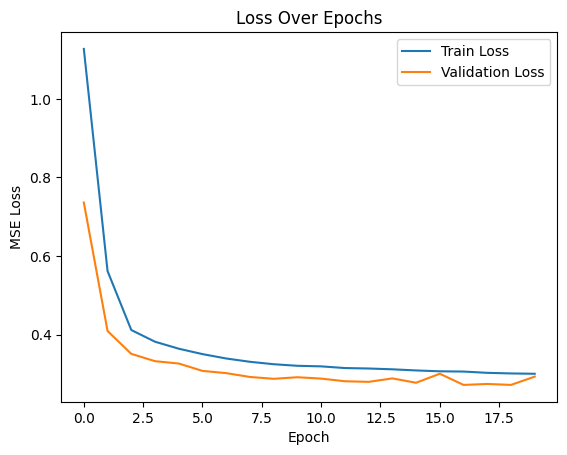

In [5]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [11]:
import torch.nn.functional as F

# Load validation data
val_data = torch.load("data/Validation_1to5.pt", weights_only=False)
val_inputs = val_data["synthetic_data"]       # [N_val, 1024]
val_num_layers = val_data["num_layers"]       # [N_val]
val_material_params = val_data["material_params"]  # list of [(n+ik, d), ...]

# Create validation dataset and loader
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_num_layers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Put model in evaluation mode
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, num_layers in val_loader:
        inputs = inputs.unsqueeze(1).float() # [batch, 1, 1024]

        # One-hot encode the number of layers (labels are from 1 to MAX_LAYERS)
        cond = F.one_hot(num_layers - 1, num_classes=MAX_LAYERS).float()  # [batch, MAX_LAYERS]

        # Forward pass with conditioning
        outputs = model(inputs, cond)  # [batch, MAX_LAYERS * PARAMS_PER_LAYER]

        # Store predictions and true values (material_params)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(val_material_params[:len(outputs)])  # Align with batch size

print("Validation completed. Number of samples evaluated:", len(all_preds))

Validation completed. Number of samples evaluated: 400


In [15]:
all_preds

[array([ 3.6102397e+00, -4.4522688e-02,  5.2093779e-04,  4.4537008e-02,
         5.7106093e-04, -9.6078264e-05, -2.6033297e-02,  7.8252517e-04,
         1.8076644e-05, -5.8876432e-02, -1.5869495e-03,  7.9208294e-06,
        -6.6757232e-02, -1.6191443e-03, -8.9070454e-08], dtype=float32),
 array([ 3.1408257e+00, -4.1317042e-02,  5.1139132e-04,  3.0327711e+00,
        -3.8153160e-02,  3.2515245e-04, -1.0636838e-01,  2.3186803e-03,
         8.0563841e-06, -2.2547536e-02, -1.3937680e-03,  5.8873957e-06,
         2.7949952e-02, -2.8144305e-03,  9.4804600e-06], dtype=float32),
 array([ 2.2003677e+00, -4.3753266e-02,  4.9234193e-04,  2.0945196e+00,
        -3.7262000e-02,  2.8778779e-04,  2.2397324e-02, -3.3679213e-03,
         2.7759379e-05,  7.2098449e-03, -3.9845416e-03,  2.0067337e-05,
        -2.7413629e-03, -3.3891667e-03,  1.3662822e-05], dtype=float32),
 array([ 2.7897322e+00, -4.3493230e-02,  3.0711421e-04,  3.1065204e+00,
        -3.7513468e-02,  1.6739182e-04,  3.0924168e+00, -3.81

In [22]:
print(val_num_layers[0])
print(val_material_params[0])

print(all_preds[0])

tensor(1)
[((3.9212767768307852-0.0005648587999386306j), 0.00034235674891596395)]
[ 3.6102397e+00 -4.4522688e-02  5.2093779e-04  4.4537008e-02
  5.7106093e-04 -9.6078264e-05 -2.6033297e-02  7.8252517e-04
  1.8076644e-05 -5.8876432e-02 -1.5869495e-03  7.9208294e-06
 -6.6757232e-02 -1.6191443e-03 -8.9070454e-08]
